In [1]:
import numpy as np
import pandas as pd

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    classification_report, confusion_matrix, log_loss
)
import plotly.graph_objects as go
from cassandra.cluster import Cluster
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
session.set_keyspace('data_stock')

In [3]:

rows_price = session.execute("""
    SELECT * FROM candlestick_data ALLOW FILTERING
""")
df_candlestick_latest = pd.DataFrame(rows_price)
df_candlestick_latest['time'] = pd.to_datetime(df_candlestick_latest['time'])
df_candlestick_latest = df_candlestick_latest.sort_values(['symbol', 'time'])

In [4]:
import ta
def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym['ema5'] = df_sym['close_price'].ewm(span=5, adjust=False).mean()
        df_sym['ema15'] = df_sym['close_price'].ewm(span=15, adjust=False).mean()
        df_sym['ema35'] = df_sym['close_price'].ewm(span=35, adjust=False).mean()
        df_sym['ema89'] = df_sym['close_price'].ewm(span=89, adjust=False).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200, adjust=False).mean()
        df_sym['rsi'] = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        # ใช้แท่งล่าสุดในการประเมิน
        row = df_sym.iloc[-1]
        try:
            c = row['close_price']
            r = row['rsi']
            e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

            if c >= e5 and r >= 70:
                grade = 'a'
            elif c >= e35 and e35 >= e89:
                grade = 'b'
            elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
                grade = 'c'
            elif c < e89 and c < e200 and e89 < e200:
                grade = 'd'
            elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
                grade = 'e'
            else:
                grade = None
        except:
            grade = None

        df_result.append({'symbol': symbol, 'trend_grade': grade})

    return pd.DataFrame(df_result)

In [5]:
# 🚨 สมมุติว่าคุณมี DataFrame แบบนี้
# df_candlestick_latest.columns = ['symbol', 'time', 'close_price', 'open', 'high', 'low', 'volume']

# 🧠 เรียกใช้ฟังก์ชันของคุณ
df_graded = compute_technical_grades(df_candlestick_latest)

# ✅ ดูผลลัพธ์
df_graded.head(10)  # แสดง DataFrame ที่มีคอลัมน์ 'symbol' และ 'trend_grade'


,symbol,trend_grade
0,24CS,d
1,2S,None
2,3BBIF,b
3,A,d
4,A5,d
5,AAI,d
6,AAV,d
7,ABM,d
8,ACAP,d
9,ACC,d


In [6]:
rows_fin2 = session.execute("""
    SELECT symbol,eps,pe,pbv,percentYield FROM financal_data_fromsettradeAPI ALLOW FILTERING
""")
df_fundamental= pd.DataFrame(rows_fin2)
df_fundamental.head(10)

,symbol,eps,pe,pbv,percentyield
0,PPPM,0.02000,0.00,0.70,0.00
1,TPCH,0.24112,7.90,0.34,13.91
2,KPNREIT,NaN,NaN,0.23,0.00
3,POLY,0.27632,12.89,2.42,6.38
4,QHBREIT,NaN,NaN,0.41,0.00
5,VCOM,0.21428,7.85,1.48,10.79
6,KDH,4.12186,10.62,1.93,3.01
7,NVD,-0.00942,38.87,0.32,0.00
8,JDF,0.04224,12.19,1.35,4.85
9,SVR,-0.03402,0.00,0.34,0.00


In [7]:
rows_price = session.execute("""
    SELECT * FROM candlestick_data ALLOW FILTERING
""")
df_candlestick_latest = pd.DataFrame(rows_price)
df_candlestick_latest['time'] = pd.to_datetime(df_candlestick_latest['time'])
df_candlestick_latest = df_candlestick_latest.sort_values(['symbol', 'time'])

In [8]:
# ✅ 1) ดึงแท่งล่าสุดของแต่ละ symbol
df_latest_candle = (
    df_candlestick_latest.sort_values("time")
    .groupby("symbol", as_index=False)
    .tail(1)  # หรือใช้ .last() ก็ได้หลัง sort แล้ว
)

# ✅ 2) Merge กับข้อมูล fundamental
df = pd.merge(df_fundamental, df_latest_candle, on="symbol", how="inner")

# ✅ 3) คำนวณ marketcap
df["marketcap"] = df["close_price"] * df["volume"]


In [9]:
df.head()

,symbol,eps,pe,pbv,percentyield,time,close_price,high_price,low_price,open_price,value,volume,marketcap
0,PPPM,0.02000,0.00,0.70,0.00,2025-05-28,0.49,0.51,0.48,0.49,0.0,313650,153688.502991
1,TPCH,0.24112,7.90,0.34,13.91,2025-05-28,3.08,3.10,3.04,3.10,0.0,52708,162340.635979
2,KPNREIT,NaN,NaN,0.23,0.00,2025-05-22,2.56,2.56,2.56,2.56,0.0,100,255.999994
3,POLY,0.27632,12.89,2.42,6.38,2025-05-28,6.95,6.95,6.65,6.90,0.0,5100,35444.999027
4,QHBREIT,NaN,NaN,0.41,0.00,2025-05-28,3.44,3.44,3.42,3.44,0.0,140301,482635.448028


In [10]:
# ✅ Clustering กลุ่ม A–E ด้วย KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
df.loc[X.index, 'group'] = kmeans_labels

group_map = {i: chr(65+i) for i in range(5)}
df['group'] = df['group'].map(group_map)

In [11]:
from sklearn.metrics import silhouette_score

# ✅ Inertia (ค่า sum of squared distances ภายใน cluster → ยิ่งต่ำยิ่งดี)
print("Inertia:", kmeans.inertia_)

# ✅ Silhouette Score ([-1,1] → ยิ่งใกล้ 1 ยิ่งดี, ใกล้ 0 = ซ้อนทับกัน, <0 = cluster ซ้อนผิดที่)
sil_score = silhouette_score(X_scaled, kmeans_labels)
print("Silhouette Score:", sil_score)


Inertia: 2056.315535227477
Silhouette Score: 0.41687771985600774


In [12]:
df.head(10)

,symbol,eps,pe,pbv,percentyield,time,close_price,high_price,low_price,open_price,value,volume,marketcap,group
0,PPPM,0.02000,0.00,0.70,0.00,2025-05-28,0.49,0.51,0.48,0.49,0.0,313650,153688.502991,A
1,TPCH,0.24112,7.90,0.34,13.91,2025-05-28,3.08,3.10,3.04,3.10,0.0,52708,162340.635979,B
2,KPNREIT,NaN,NaN,0.23,0.00,2025-05-22,2.56,2.56,2.56,2.56,0.0,100,255.999994,NaN
3,POLY,0.27632,12.89,2.42,6.38,2025-05-28,6.95,6.95,6.65,6.90,0.0,5100,35444.999027,B
4,QHBREIT,NaN,NaN,0.41,0.00,2025-05-28,3.44,3.44,3.42,3.44,0.0,140301,482635.448028,NaN
5,VCOM,0.21428,7.85,1.48,10.79,2025-05-28,2.50,2.62,2.50,2.56,0.0,335100,837750.000000,B
6,KDH,4.12186,10.62,1.93,3.01,2025-05-22,85.00,85.00,84.75,85.00,0.0,1200,102000.000000,A
7,NVD,-0.00942,38.87,0.32,0.00,2025-05-28,1.00,1.02,1.00,1.02,0.0,16301,16301.000000,A
8,JDF,0.04224,12.19,1.35,4.85,2025-05-28,1.84,1.85,1.84,1.85,0.0,200,368.000007,B
9,SVR,-0.03402,0.00,0.34,0.00,2025-05-28,0.58,0.59,0.57,0.58,0.0,47400,27491.999209,A


In [13]:
# ✅ 1) สมมติว่า df_graded มี: symbol | trend_grade
#         และ df มี:        symbol | group

# ✅ 2) Merge โดยใช้คอลัมน์ 'symbol'
df_merged = pd.merge(df, df_graded[['symbol', 'trend_grade']], on='symbol', how='inner')

# ✅ 3) สร้างคอลัมน์ quadrant (เช่น Aa, Be, Dc, etc.)
df_merged['quadrant'] = df_merged['group'] + df_merged['trend_grade']


In [14]:
df_merged[['symbol', 'group', 'trend_grade', 'quadrant']].head(10)


,symbol,group,trend_grade,quadrant
0,PPPM,A,None,NaN
1,TPCH,B,d,Bd
2,KPNREIT,NaN,d,NaN
3,POLY,B,d,Bd
4,QHBREIT,NaN,d,NaN
5,VCOM,B,None,NaN
6,KDH,A,d,Ad
7,NVD,A,d,Ad
8,JDF,B,d,Bd
9,SVR,A,d,Ad


In [15]:
df_merged.head(10)

,symbol,eps,pe,pbv,percentyield,time,close_price,high_price,low_price,open_price,value,volume,marketcap,group,trend_grade,quadrant
0,PPPM,0.02000,0.00,0.70,0.00,2025-05-28,0.49,0.51,0.48,0.49,0.0,313650,153688.502991,A,None,NaN
1,TPCH,0.24112,7.90,0.34,13.91,2025-05-28,3.08,3.10,3.04,3.10,0.0,52708,162340.635979,B,d,Bd
2,KPNREIT,NaN,NaN,0.23,0.00,2025-05-22,2.56,2.56,2.56,2.56,0.0,100,255.999994,NaN,d,NaN
3,POLY,0.27632,12.89,2.42,6.38,2025-05-28,6.95,6.95,6.65,6.90,0.0,5100,35444.999027,B,d,Bd
4,QHBREIT,NaN,NaN,0.41,0.00,2025-05-28,3.44,3.44,3.42,3.44,0.0,140301,482635.448028,NaN,d,NaN
5,VCOM,0.21428,7.85,1.48,10.79,2025-05-28,2.50,2.62,2.50,2.56,0.0,335100,837750.000000,B,None,NaN
6,KDH,4.12186,10.62,1.93,3.01,2025-05-22,85.00,85.00,84.75,85.00,0.0,1200,102000.000000,A,d,Ad
7,NVD,-0.00942,38.87,0.32,0.00,2025-05-28,1.00,1.02,1.00,1.02,0.0,16301,16301.000000,A,d,Ad
8,JDF,0.04224,12.19,1.35,4.85,2025-05-28,1.84,1.85,1.84,1.85,0.0,200,368.000007,B,d,Bd
9,SVR,-0.03402,0.00,0.34,0.00,2025-05-28,0.58,0.59,0.57,0.58,0.0,47400,27491.999209,A,d,Ad


In [27]:
df_merged.columns

Index(['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'time', 'close_price',
       'high_price', 'low_price', 'open_price', 'value', 'volume', 'marketcap',
       'group', 'trend_grade', 'quadrant'],
      dtype='object')

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


In [33]:
df=df_merged

In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# ✅ Features และ Quadrant (สมมุติ df เตรียมไว้แล้ว)
features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
df = df.dropna(subset=features + ['group', 'trend_grade'])
df['quadrant'] = df['group'] + df['trend_grade']  # เช่น 'Aa', 'Bb'

# ✅ Encode Quadrant
le = LabelEncoder()
y_encoded = le.fit_transform(df['quadrant'])

# ✅ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
X_indices = df.index.values  # เก็บ index เดิมไว้

# ✅ Split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    torch.tensor(X_scaled, dtype=torch.float32),
    torch.tensor(y_encoded, dtype=torch.long),
    X_indices,
    test_size=0.2,
    random_state=42
)

# ✅ Neural Network
class ANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# ✅ Train model
input_size = X_train.shape[1]
num_classes = len(le.classes_)
model = ANN(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# ✅ Predict
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred = torch.argmax(y_pred_logits, axis=1)

# ✅ Score
acc = accuracy_score(y_test.numpy(), y_pred.numpy())
f1 = f1_score(y_test.numpy(), y_pred.numpy(), average='macro')
print(f"\n📊 Accuracy: {acc:.4f}")
print(f"🎯 F1 Score (macro): {f1:.4f}")


Epoch 10 | Loss: 2.2968
Epoch 20 | Loss: 1.9622
Epoch 30 | Loss: 1.5749
Epoch 40 | Loss: 1.2582
Epoch 50 | Loss: 1.0598
Epoch 60 | Loss: 0.9374
Epoch 70 | Loss: 0.8589
Epoch 80 | Loss: 0.8045
Epoch 90 | Loss: 0.7638
Epoch 100 | Loss: 0.7254

📊 Accuracy: 0.8503
🎯 F1 Score (macro): 0.1953


In [40]:
df_pred = pd.DataFrame({
    'stock': df.loc[idx_test, 'symbol'].values,  # เปลี่ยนจาก 'stock' → 'symbol'
    'predicted_quadrant': predicted_quadrants
})



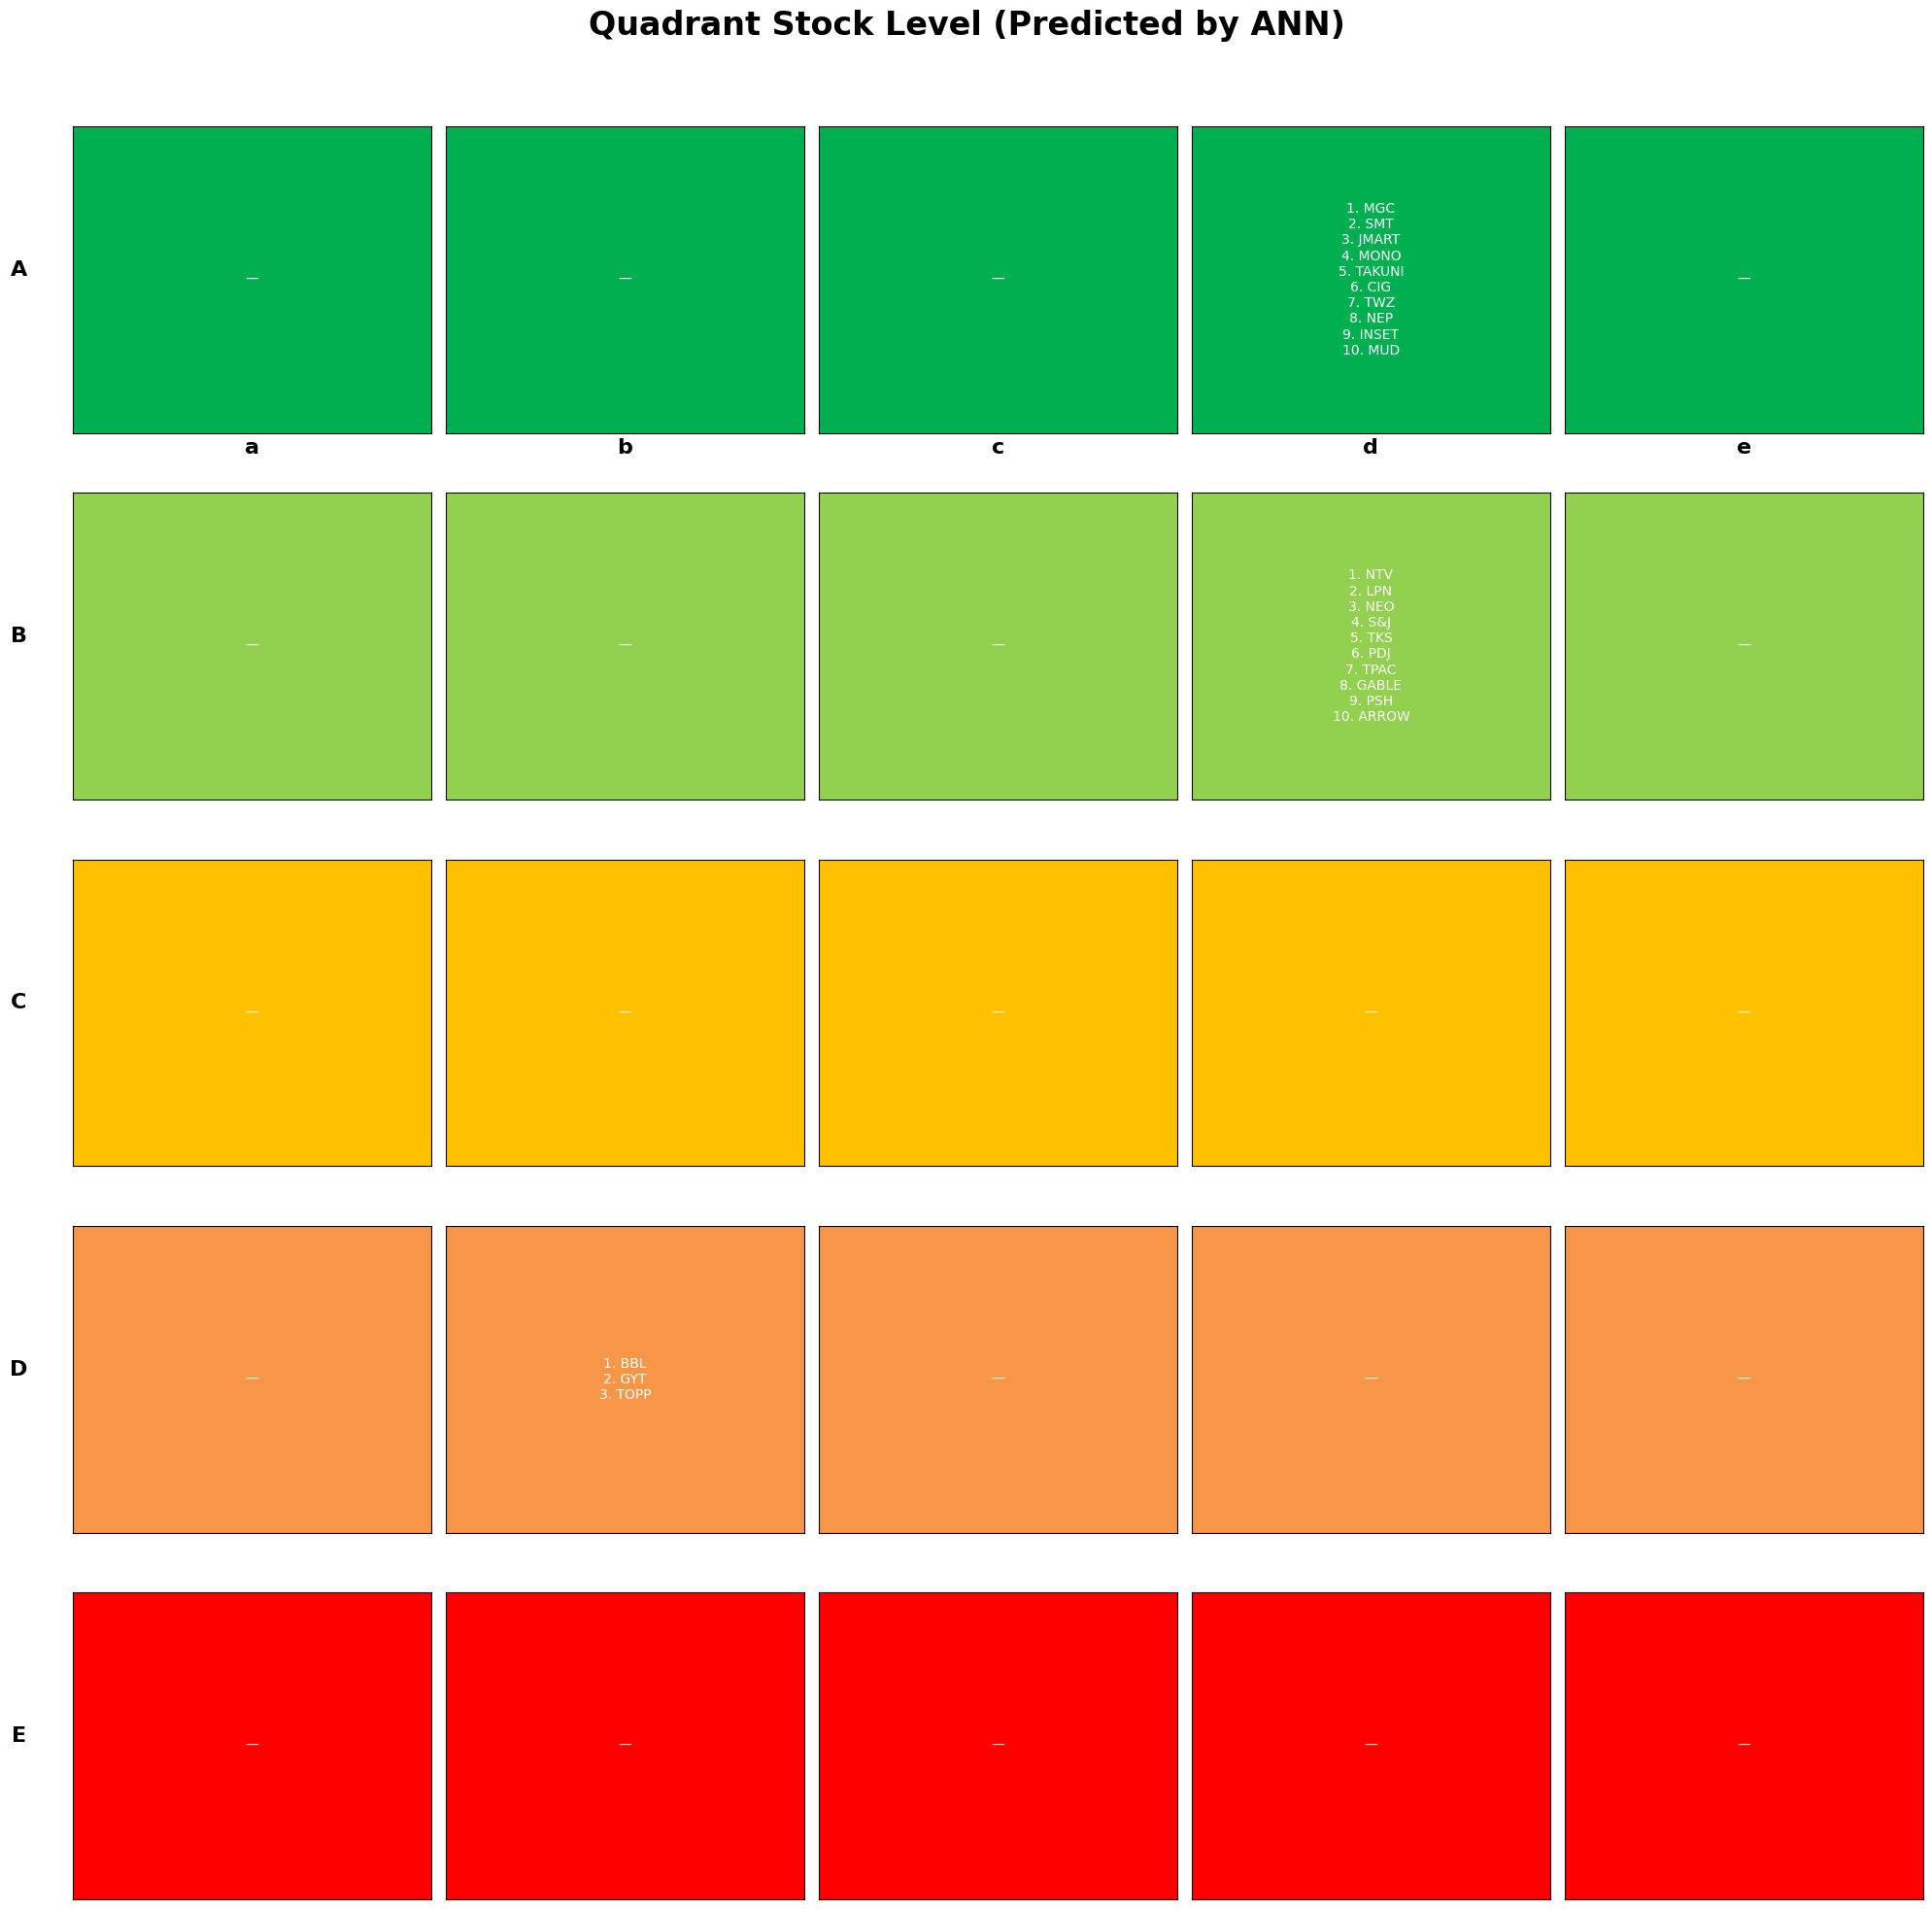

In [41]:
# ✅ เตรียม layout
financial_levels = ['A', 'B', 'C', 'D', 'E']
trend_levels = ['a', 'b', 'c', 'd', 'e']
color_map = {
    'A': '#00b050',  # เขียวเข้ม
    'B': '#92d050',
    'C': '#ffc000',
    'D': '#f79646',
    'E': '#ff0000'   # แดง
}

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for i, f in enumerate(financial_levels):
    for j, t in enumerate(trend_levels):
        q = f + t
        ax = axes[i, j]
        stocks = df_pred[df_pred['predicted_quadrant'] == q]['stock'].tolist()

        # แสดงชื่อหุ้น
        text = "\n".join([f"{k+1}. {s}" for k, s in enumerate(stocks[:10])]) or "—"
        ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=10, color='white')
        ax.set_title(q, fontsize=14, weight='bold', color='white')
        ax.set_facecolor(color_map[f])
        ax.set_xticks([])
        ax.set_yticks([])

# ✅ แกน
for ax, label in zip(axes[:, 0], financial_levels):
    ax.set_ylabel(label, rotation=0, labelpad=40, fontsize=16, weight='bold')

for ax, label in zip(axes[0], trend_levels):
    ax.set_xlabel(label, fontsize=16, weight='bold')

fig.suptitle("Quadrant Stock Level (Predicted by ANN)", fontsize=24, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
